# Libraries

In [30]:
import os
from pathlib import Path
from glob import glob
import pandas as pd
from pydicom import dcmread
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'nrrd'

In [7]:
notebooks_path = Path.cwd()
repo_path = notebooks_path.parent
os.chdir(str(notebooks_path))
#print current working directory
print(notebooks_path)

/home/ricardino/Documents/MAIA/tercer_semestre/Extra_activities/INCan/Added_value_feature_uncertainty/notebooks


# Funtions and classes

In [8]:
#Valid patients in the dataset
pat_list = [x for x in range(1,46) if x not in [1, 6, 10, 13, 17, 18, 19, 22, 23, 27, 30, 32]] #list of valid patients

In [17]:
def get_PathsAndNums():
    """Returns files and patient numbers, NOT sorted

    Returns:
        2 lists: files and numbers lists
    """
    #Get paths  
    folder_path = str(repo_path) + '/data/images/SET'
    p = Path(folder_path).glob('**/*')
    files = [x.relative_to(repo_path) for x in p if x.is_file()]
    #Get patient number
    p = Path(folder_path).glob('**/*')
    pat_num = [int(str(x.relative_to(repo_path).name)[4:6].replace('_','')) for x in p if x.is_file()] #Get patient number
    
    return files, pat_num

def get_PathsAndNums_seg(radiologist, time, stype):
    """Returns files and patient numbers, NOT sorted

    Returns:
        2 lists: files and numbers lists
    """
    #Get paths  
    folder_path = str(repo_path) + f'/data/segmentations/{radiologist}_{time}_seg'
    p = Path(folder_path).glob(f'*_{stype}_{radiologist}.seg.nrrd')
    files = [x.relative_to(repo_path) for x in p if x.is_file()]
    #Get patient number
    p = Path(folder_path).glob(f'*_{stype}_{radiologist}.seg.nrrd')
    pat_num = [int(str(x.relative_to(repo_path).name)[:2].replace('_','')) for x in p if x.is_file()] #Get patient number
    
    return files, pat_num

def info_images_dataframe(pat_list):
    """returns dataframe with metadata

    Returns:
        _type_: _description_
    """
    #image dataframe
    df = pd.DataFrame() #Save paths in df
    paths_list, pat_nums = get_PathsAndNums()
    paths = pd.DataFrame({ #save in frame
        'path': paths_list, 
        'pat_num': pat_nums
    })
    paths = paths.sort_values('pat_num') #Sort paths by alphabetic order
    df = pd.concat([df,paths], ignore_index=True) #Concatenate with previous info
    
    df = df[df['pat_num'].isin(pat_list)].reset_index(drop=True) #Filter by patient list
    
    return df

In [10]:
def add_segColumns(df, radiologist, time, stype):
    """get dataframe with column of segmentation paths added

    Args:
        df (dataframe): input dataframe
        radiologist (str): radiologist first letter
        time (srt): first or second time (1,2)
        stype (srt): General (G) or focal (F)

    Returns:
        dataframe: output dataframe
    """
    paths_list, pat_nums = get_PathsAndNums_seg(radiologist, time, stype)
    column_name = f'{radiologist}_{time}_{stype}'
    paths = pd.DataFrame({ #save in frame
        column_name: paths_list, 
        'pat_num': pat_nums
    })
    paths = paths.sort_values('pat_num') #Sort paths by alphabetic order
    
    
    paths = paths[paths['pat_num'].isin(pat_list)].reset_index(drop=True) #Filter by patient list
    df[column_name] = paths[column_name]
    
    return df
    

In [11]:
def get_metadata(pat_list):

    df = info_images_dataframe(pat_list)
    for radiologist in ['L', 'V', 'M']:
        for time in ['1', '2']:
            for stype in ['G', 'F']:
                df = add_segColumns(df, radiologist, time, stype)
                
    df.to_csv(str(repo_path) + '/data/metadata.csv', index=False)
    
    return df

# Get metadata

In [21]:
meta = get_metadata(pat_list)

# Visualize

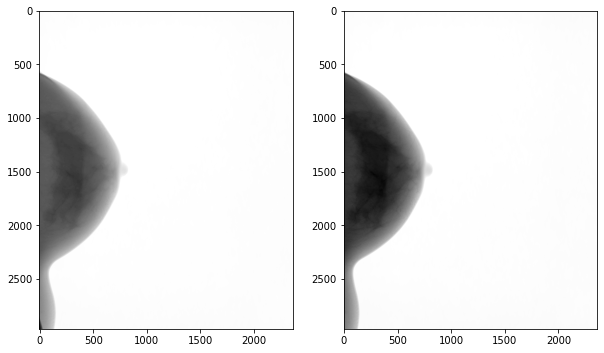

In [29]:
path_SC = str(repo_path) + '/data/images/SMC/Pat_2_RCC_SMC.dcm' 
path_CM = str(repo_path) + '/data/images/CMC_t1/Pat_2_RCC_CMC_t1.dcm'
ds_SC = dcmread(path_SC)
ds_CM = dcmread(path_CM)
#show images
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(ds_SC.pixel_array, cmap='gray')
axs[1].imshow(ds_CM.pixel_array, cmap='gray')

In [ ]:
# function to translate the segmentation into a mask
def get_mask(path):
    """Returns a mask from a segmentation file

    Args:
        path (str): path to the segmentation file

    Returns:
        numpy.array: mask
    """

    data, header = nrrd.read(path)
    mask = np.zeros(data.shape)
    mask[data == 1] = 1
    return mask